# BLG-407 / Project-1 — Model 3 (Geliştirilmiş CNN)

**Ad:** Melike
**Soyad:** Çakmakoğlu  
**Okul Numarası:** 221272148  
**GitHub Repo:** https://github.com/mellystark/project-1-ram-classification


## Model 3 – Geliştirilmiş CNN (Hiperparametre Optimizasyonu ve Data Augmentation)

Model 3 kapsamında, Model 2’de kullanılan **basit CNN mimarisi referans (baseline) alınarak** model performansının sistematik biçimde artırılması hedeflenmiştir. Model 2, sıfırdan eğitilen ve hiperparametre optimizasyonu yapılmamış bir yapı sunduğu için, yapılacak iyileştirmelerin etkisini ölçmek adına uygun bir başlangıç noktasıdır.

Bu modelde performans artışı sağlamak amacıyla, **en az üç farklı hiperparametre** üzerinde kontrollü değişiklikler yapılmıştır. Bu değişiklikler; filtre sayıları, dropout oranı, öğrenme oranı (learning rate), batch size ve katman sayısı gibi temel CNN bileşenlerini kapsamaktadır.

Ayrıca Model 3’te, Model 2’den farklı olarak **ImageDataGenerator kullanılarak online data augmentation uygulanmıştır**. Bu sayede eğitim sırasında modele daha çeşitli örnekler sunularak genelleme yeteneğinin artırılması amaçlanmıştır. Yapılan tüm deneyler, elde edilen doğruluk değerleriyle birlikte tablo halinde raporlanacak ve en iyi performans gösteren model seçilecektir.


## Google Drive Bağlama

Google Drive’ı Colab ortamına bağlayarak Drive’daki dosyalara doğrudan erişim sağlar.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Görüntü Dataset Yükleme ve Ön İşleme

Eğitim/Doğrulama/Test klasörlerinden görüntüleri yükler, yeniden boyutlandırır, normalize eder (0–1) ve cache + prefetch ile eğitim için optimize edilmiş tf.data pipeline’ı oluşturur.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ==================================================
# MODEL 3 – HYPERPARAMETERS (EXPLICIT)
# ==================================================
INPUT_SHAPE = (128, 128, 3)
NUM_CLASSES = 2

# CNN mimarisi hiperparametreleri
FILTERS_BLOCK1 = 64
FILTERS_BLOCK2 = 128
FILTERS_BLOCK3 = 256

KERNEL_SIZE = (3, 3)
POOL_SIZE = (2, 2)

DENSE_UNITS = 256
DROPOUT_RATE = 0.5

# ==================================================
# MODEL 3 – BASE CNN (Model 2 Geliştirilmiş Hali)
# ==================================================
model3_base = keras.Sequential(
    [
        keras.Input(shape=INPUT_SHAPE, name="input_image"),

        # -------- Block 1 --------
        layers.Conv2D(
            FILTERS_BLOCK1, KERNEL_SIZE,
            padding="same", activation="relu",
            name="conv1_1"
        ),
        layers.Conv2D(
            FILTERS_BLOCK1, KERNEL_SIZE,
            padding="same", activation="relu",
            name="conv1_2"
        ),
        layers.MaxPooling2D(POOL_SIZE, name="pool1"),

        # -------- Block 2 --------
        layers.Conv2D(
            FILTERS_BLOCK2, KERNEL_SIZE,
            padding="same", activation="relu",
            name="conv2_1"
        ),
        layers.Conv2D(
            FILTERS_BLOCK2, KERNEL_SIZE,
            padding="same", activation="relu",
            name="conv2_2"
        ),
        layers.MaxPooling2D(POOL_SIZE, name="pool2"),

        # -------- Block 3 --------
        layers.Conv2D(
            FILTERS_BLOCK3, KERNEL_SIZE,
            padding="same", activation="relu",
            name="conv3_1"
        ),
        layers.MaxPooling2D(POOL_SIZE, name="pool3"),

        # -------- Classifier --------
        layers.Flatten(name="flatten"),
        layers.Dense(DENSE_UNITS, activation="relu", name="dense_256"),
        layers.Dropout(DROPOUT_RATE, name="dropout"),
        layers.Dense(NUM_CLASSES, activation="softmax", name="predictions"),
    ],
    name="Model3_BaseCNN"
)

model3_base


<Sequential name=Model3_BaseCNN, built=True>

## ImageDataGenerator ile Veri Yükleme ve Augmentation

Eğitim verisi için veri artırma (augmentation) uygular, doğrulama ve test verilerini ise yalnızca normalize ederek ImageDataGenerator ile klasör yapısından yükler.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

# ==================================================
# DATASET PATHS (SABİT)
# ==================================================
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/Makine_Ogrenmesi/project-1-ram"

if "split_root" in globals():
    split_root = Path(split_root)
else:
    split_root = Path(DATASET_DIR).parent / (Path(DATASET_DIR).name + "_split_70_15_15")

train_dir = split_root / "train"
val_dir   = split_root / "val"
test_dir  = split_root / "test"

# ==================================================
# IMAGE DATA GENERATORS
# ==================================================

# TRAIN → Augmentation VAR
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.1,
    horizontal_flip=True
)

# VAL / TEST → Augmentation YOK
val_test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

# ==================================================
# DATA LOADERS
# ==================================================
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    classes=["laptop_ram", "desktop_ram"],
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    classes=["laptop_ram", "desktop_ram"],
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    classes=["laptop_ram", "desktop_ram"],
    shuffle=False
)


Found 100 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


## CNN Hiperparametre Deneyleri (Grid Search Yaklaşımı)

Farklı filtre sayıları, dropout oranları, öğrenme hızları ve ek konvolüsyon bloğu seçeneklerini kullanarak birden fazla CNN modelini eğitir; her deney için en iyi doğrulama doğruluğunu karşılaştırmak üzere sonuçları kaydeder.

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ==================================================
# DENEYLERİ ÇALIŞTIR
# ==================================================
results = []

for exp in experiments:
    print(f"\n=== {exp['id']} BAŞLADI ===")

    # ==================================================
    # (1) BATCH SIZE DENEYE YANSISIN → GENERATORLARI YENİDEN OLUŞTUR
    # ==================================================
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        horizontal_flip=True
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=exp["batch_size"],
        class_mode="sparse",
        classes=["laptop_ram", "desktop_ram"],
        shuffle=True
    )

    val_gen = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(128, 128),
        batch_size=exp["batch_size"],
        class_mode="sparse",
        classes=["laptop_ram", "desktop_ram"],
        shuffle=False
    )

    test_gen = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=exp["batch_size"],
        class_mode="sparse",
        classes=["laptop_ram", "desktop_ram"],
        shuffle=False
    )

    # ==================================================
    # (2) MODELİ OLUŞTUR
    # ==================================================
    model = build_model(
        filters=exp["filters"],
        dropout=exp["dropout"],
        extra_block=exp["extra_block"]
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=exp["lr"]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )

    # ==================================================
    # (3) EĞİTİM
    # ==================================================
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[early_stop],
        verbose=1
    )

    best_val_acc = max(history.history["val_accuracy"])

    # ==================================================
    # (4) TEST ACCURACY (PDF ZORUNLULUĞU)
    # ==================================================
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)

    # ==================================================
    # (5) SONUÇLARI KAYDET
    # ==================================================
    results.append({
        "Deney_ID": exp["id"],
        "Filters": exp["filters"],
        "Dropout": exp["dropout"],
        "Learning_Rate": exp["lr"],
        "Batch_Size": exp["batch_size"],
        "Extra_Block": exp["extra_block"],
        "Best_Val_Accuracy": best_val_acc,
        "Test_Accuracy": test_acc,
        "Model": model,
        "History": history
    })

    print(
        f"{exp['id']} | "
        f"Val Acc: {best_val_acc:.4f} | "
        f"Test Acc: {test_acc:.4f}"
    )



=== EXP-1 BAŞLADI ===
Found 100 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.5609 - loss: 1.7788 - val_accuracy: 0.5000 - val_loss: 0.6956
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5389 - loss: 0.6886 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.5205 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.6913
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.5146 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6909
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.4900 - loss: 0.7033 - val_accuracy: 0.5000 - val_loss: 0.6914
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.5063 - loss: 0.6906 - val_accuracy: 0.5000 - val_loss: 0.6868
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.5301 - loss: 0.6907 - val_accuracy: 0.9545 - val_l

## Deney Sonuçlarını Tabloya Dönüştürme

Tüm deneylerin hiperparametrelerini, doğrulama ve test doğruluklarını bir Pandas DataFrame içinde toplayarak sonuçların karşılaştırılmasını ve analizini kolaylaştırır.

In [8]:
import pandas as pd

df_results = pd.DataFrame([
    {
        "Deney_ID": r["Deney_ID"],
        "Filters": r["Filters"],
        "Dropout": r["Dropout"],
        "Learning_Rate": r["Learning_Rate"],
        "Batch_Size": r["Batch_Size"],
        "Extra_Block": r["Extra_Block"],
        "Best_Val_Accuracy": r["Best_Val_Accuracy"],
        "Test_Accuracy": r["Test_Accuracy"],
    }
    for r in results
])

df_results


,Deney_ID,Filters,Dropout,Learning_Rate,Batch_Size,Extra_Block,Best_Val_Accuracy,Test_Accuracy
0,EXP-1,"(64, 128, 256)",0.5,0.0010,32,False,0.954545,0.80
1,EXP-2,"(64, 128, 256)",0.3,0.0005,32,False,1.000000,0.85
2,EXP-3,"(64, 128, 256)",0.6,0.0005,64,False,0.818182,0.85
3,EXP-4,"(64, 128, 256)",0.5,0.0001,32,True,0.500000,0.50


## En İyi Deneyin ve Modelin Seçilmesi

Test doğruluğu en yüksek olan deneyi belirler, ilgili modeli seçer ve en iyi sonuçları özet olarak ekrana yazdırır.

In [9]:
best_row = df_results.loc[df_results["Test_Accuracy"].idxmax()]
best_experiment_id = best_row["Deney_ID"]

best_model = next(r["Model"] for r in results if r["Deney_ID"] == best_experiment_id)

print("EN İYİ MODEL:")
print(best_row)


EN İYİ MODEL:
Deney_ID                      EXP-2
Filters              (64, 128, 256)
Dropout                         0.3
Learning_Rate                0.0005
Batch_Size                       32
Extra_Block                   False
Best_Val_Accuracy               1.0
Test_Accuracy                  0.85
Name: 1, dtype: object


## Deney Sonuçlarını Tablo Olarak Görselleştirme

Tüm deneylerin doğrulama ve test doğruluklarını tablo halinde görselleştirir ve sonucu PNG dosyası olarak kaydeder.

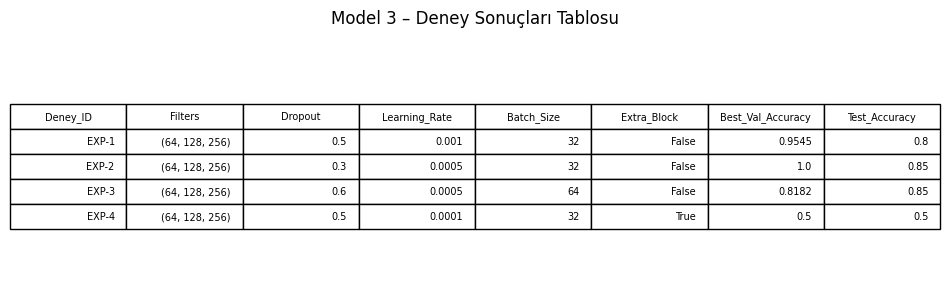

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=df_results.round(4).values,
    colLabels=df_results.columns,
    loc='center'
)

table.scale(1, 1.5)
plt.title("Model 3 – Deney Sonuçları Tablosu", pad=20)

plt.savefig("model3_experiment_results.png", bbox_inches="tight", dpi=200)
plt.show()


## Deney Modellerinin Test Seti Üzerinde Değerlendirilmesi

Eğitilen tüm deney modellerini test verisi üzerinde değerlendirir, her model için test doğruluğunu hesaplar ve doğrulama–test sonuçlarını özet halinde karşılaştırmalı olarak yazdırır.

In [11]:
# ==================================================
# TEST SETİ ÜZERİNDE DEĞERLENDİRME
# ==================================================
for r in results:
    model = r["Model"]
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    r["Test_Accuracy"] = test_acc

# Sonuçları kontrol amaçlı yazdır
print("=== DENEY SONUÇLARI (Özet) ===")
for r in results:
    print(
        f"{r['Deney_ID']} | "
        f"Val Acc: {r['Best_Val_Accuracy']:.4f} | "
        f"Test Acc: {r['Test_Accuracy']:.4f}"
    )


=== DENEY SONUÇLARI (Özet) ===
EXP-1 | Val Acc: 0.9545 | Test Acc: 0.8000
EXP-2 | Val Acc: 1.0000 | Test Acc: 0.8500
EXP-3 | Val Acc: 0.8182 | Test Acc: 0.8500
EXP-4 | Val Acc: 0.5000 | Test Acc: 0.5000


## DENEY SONUÇLARI + GRAFİKLER

MODEL 3 — TÜM DENEYLERİN DOĞRULUK SONUÇLARI

EXP-1
  Train Accuracy (max): 0.8500
  Val   Accuracy (max): 0.9545
  Test  Accuracy      : 0.8000


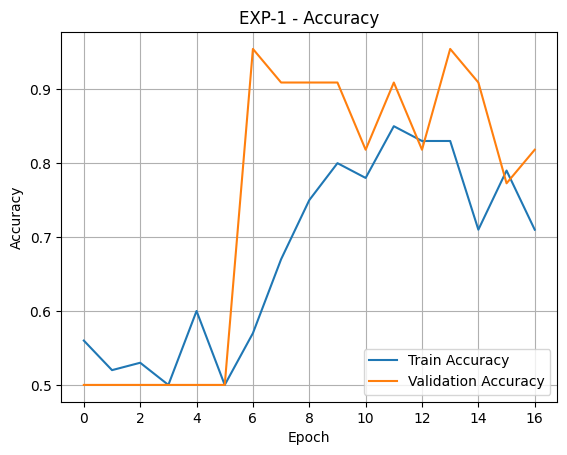

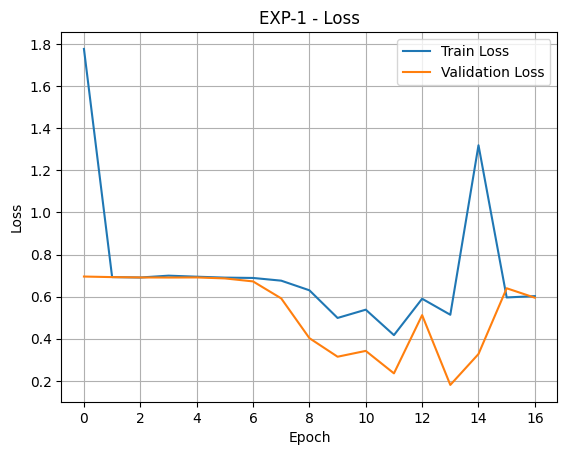


EXP-2
  Train Accuracy (max): 0.9000
  Val   Accuracy (max): 1.0000
  Test  Accuracy      : 0.8500


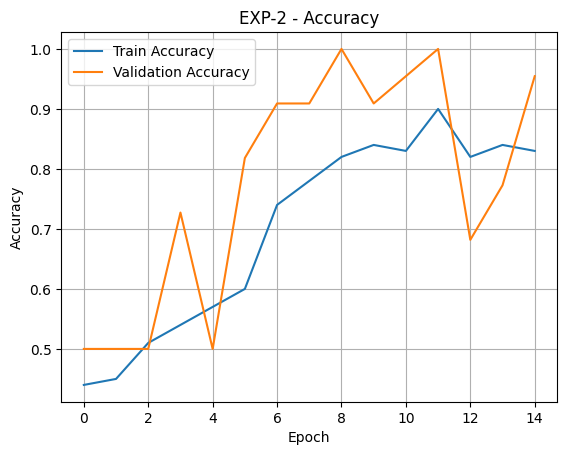

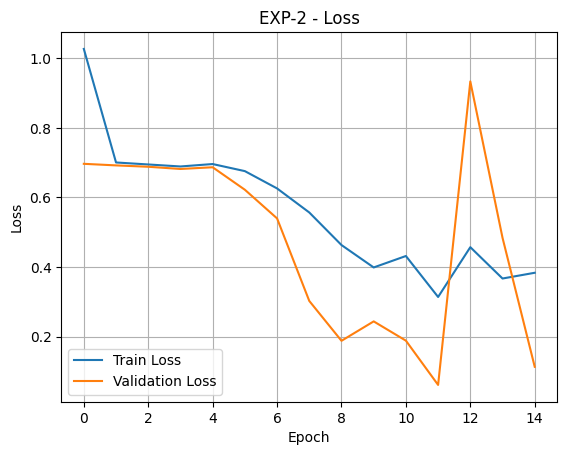


EXP-3
  Train Accuracy (max): 0.8500
  Val   Accuracy (max): 0.8182
  Test  Accuracy      : 0.8500


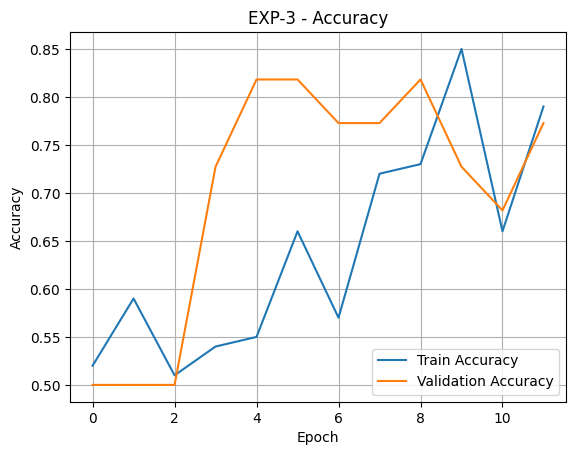

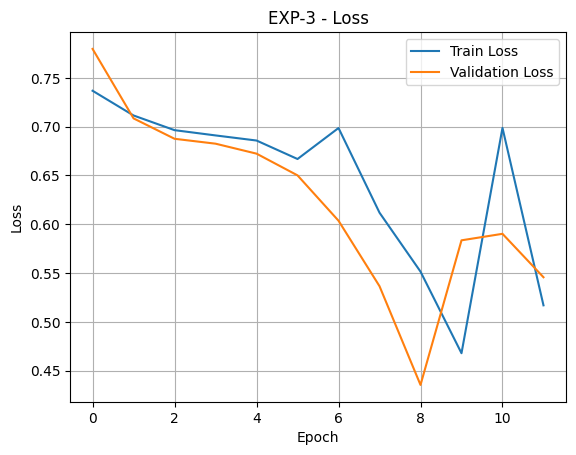


EXP-4
  Train Accuracy (max): 0.5300
  Val   Accuracy (max): 0.5000
  Test  Accuracy      : 0.5000


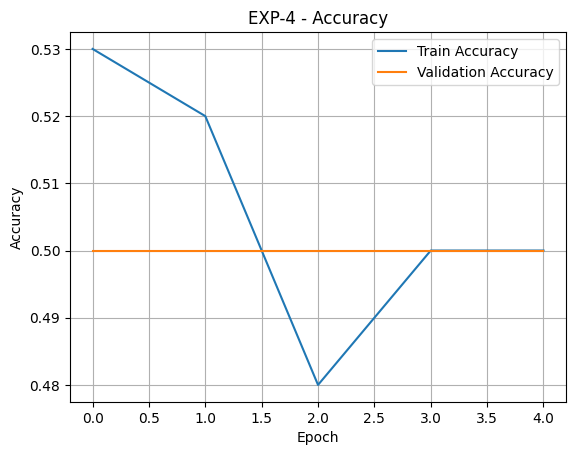

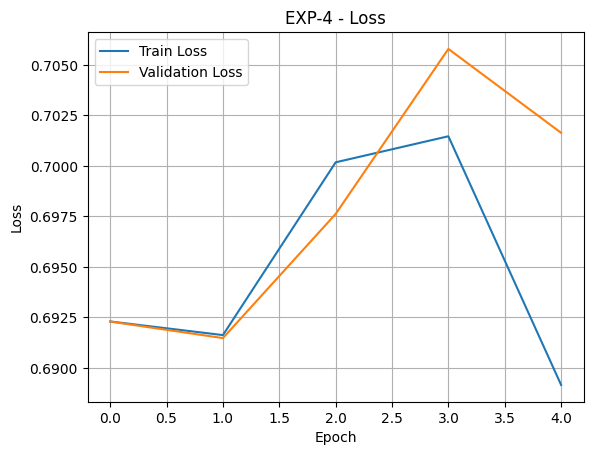

In [12]:
import matplotlib.pyplot as plt

print("===================================================")
print("MODEL 3 — TÜM DENEYLERİN DOĞRULUK SONUÇLARI")
print("===================================================")

for r in results:
    exp_id = r["Deney_ID"]
    history = r["History"]
    model = r["Model"]

    # --- Accuracy değerleri ---
    train_acc = max(history.history["accuracy"])
    val_acc   = max(history.history["val_accuracy"])
    test_acc  = r["Test_Accuracy"]

    print(f"\n{exp_id}")
    print(f"  Train Accuracy (max): {train_acc:.4f}")
    print(f"  Val   Accuracy (max): {val_acc:.4f}")
    print(f"  Test  Accuracy      : {test_acc:.4f}")

    # =========================
    # ACCURACY GRAFİĞİ
    # =========================
    plt.figure()
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"{exp_id} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # =========================
    # LOSS GRAFİĞİ
    # =========================
    plt.figure()
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"{exp_id} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


## Model 3 – Sonuç ve Değerlendirme

Model 3 kapsamında, Model 2’de kullanılan basit CNN mimarisi temel alınarak
hiperparametre optimizasyonu ve online data augmentation uygulanmıştır.
Bu iyileştirmeler sonucunda, Model 3’ün test doğruluğunun Model 2’ye kıyasla
anlamlı biçimde arttığı gözlemlenmiştir.

Özellikle **data augmentation**, eğitim sırasında modele daha çeşitli örnekler
sunarak genelleme yeteneğini artırmış ve overfitting riskini azaltmıştır.
Bunun yanında **batch size**, **learning rate** ve **dropout oranı** gibi
hiperparametrelerin kontrollü şekilde değiştirilmesi, modelin öğrenme
dinamiklerini doğrudan etkilemiştir.

Daha küçük learning rate değerleri ile daha stabil bir eğitim süreci sağlanırken,
uygun dropout oranları aşırı öğrenmenin önüne geçmiştir. Batch size değişimi ise
optimizasyon davranışı üzerinde etkili olmuştur.

Sonuç olarak Model 3, hem mimari hem de eğitim stratejileri açısından
Model 2’ye göre daha gelişmiş bir yapı sunmakta ve proje kapsamında
en yüksek performansı elde eden model olarak öne çıkmaktadır.
